# Plot Station Maps Combining CROCUS and NOAA Data

In [1]:
from PythonMETAR import Metar
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import GoogleTiles, OSM
import metpy.calc as mpcalc
from metpy.calc import reduce_point_density, wind_components
from metpy.calc import dewpoint_from_relative_humidity, wet_bulb_temperature
from metpy.calc import altimeter_to_station_pressure
from metpy.units import units
from metpy.io import parse_metar_to_dataframe
from metpy.io import metar
from metpy.plots import current_weather, sky_cover, StationPlot
import sage_data_client
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [2]:
def pressure_to_altimeter(pressure, height):
    pressure = pressure.to("hPa").m
    height = height.to("m").m
    return ((pressure - 0.3) * ((1 +(((1013.25 ** 0.190284) * 0.0065)/288) * (height / ((pressure - 0.3) ** 0.190284))) ** (1/0.190284)) * units.hPa).to("inHg")

In [2]:
wxt_global_NEIU = {'conventions': "CF 1.10",
                   'site_ID' : "NEIU",
                  'CAMS_tag' : "CMS-WXT-002",
                  'datastream' : "CMS_wxt536_NEIU_a1",
                  'datalevel' : "a1",
                   "plugin" : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                   'WSN' : 'W08D',
                  'latitude' : 41.9804526,
                  'longitude' : -87.7196038}

wxt_global_NU = {'conventions': "CF 1.10",
                  'WSN':'W099',
                   'site_ID' : "NU",
                  'CAMS_tag' : "CMS-WXT-005",
                  'datastream' : "CMS_wxt536_NU_a1",
                  'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                  'datalevel' : "a1",
                  'latitude' : 42.051469749,
                  'longitude' : -87.677667183}

wxt_global_CSU = {'conventions': "CF 1.10",
                  'WSN':'W08E',
                   'site_ID' : "CSU",
                  'CAMS_tag' : "CMS-WXT-003",
                  'datastream' : "CMS_wxt536_CSU_a1",
                  'plugin' : "local/waggle-wxt536",
                  'datalevel' : "a1",
                  'latitude' : 41.71996846,
                  'longitude' : -87.612805717}

wxt_global_ATMOS = {'conventions': "CF 1.10",
                  'WSN':'W0A4',
                   'site_ID' : "ATMOS",
                  'CAMS_tag' : "CMS-WXT-001",
                  'datastream' : "CMS_wxt536_ATMOS_a1",
                  'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                  'datalevel' : "a1",
                  'latitude' : 41.7016264,
                  'longitude' : -87.9956515}

wxt_global_UIC = {'conventions': "CF 1.10",
                  'WSN':'W096',
                   'site_ID' : "UIC",
                  'CAMS_tag' : "CMS-WXT-011",
                  'datastream' : "CMS_wxt536_UIC_a1",
                  'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                  'datalevel' : "a1",
                  'latitude' : 41.869407936,
                  'longitude' : -87.645806251}

wxt_global_CCIS = {'conventions': "CF 1.10",
                  'WSN':'W08B',
                   'site_ID' : "NEIU_CCIS",
                  'CAMS_tag' : "CMS-WXT-001",
                  'datastream' : "CMS_wxt536_NEIU_CCIS_a1",
                  'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                  'datalevel' : "a1",
                  'latitude' : 41.822966818,
                  'longitude' : -87.609655739}

wxt_global_BIG = {'conventions': "CF 1.10",
                  'WSN':'W0A0',
                   'site_ID' : "BIG",
                  'CAMS_tag' : "CMS-WXT-001",
                  'datastream' : "CMS_wxt536_BIG_a1",
                  'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                  'datalevel' : "a1",
                  'latitude' : 41.777038463,
                  'longitude' : -87.609755821}

wxt_global_HUM = {'conventions': "CF 1.10",
                  'WSN':'W0A1',
                  'site_ID' : "HUM",
                  'CAMS_tag' : "CMS-WXT-009",
                  'datastream' : "CMS_wxt536_HUM_a1",
                  'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                  'datalevel' : "a1",
                  'latitude' : 41.905428657,
                  'longitude' : -87.703076089}

wxt_global_DOWN = {'conventions': "CF 1.10",
                  'WSN':'W09D',
                  'site_ID' : "DOWN",
                  'CAMS_tag' : "CMS-WXT-013",
                  'datastream' : "CMS_wxt536_DOWN_a1",
                  'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                  'datalevel' : "a1",
                  'latitude' : 41.79459781,
                  'longitude' : -88.008268061}

wxt_global_SHEDD = {'conventions': "CF 1.10",
                  'WSN':'W09E',
                  'site_ID' : "SHEDD",
                  'CAMS_tag' : "CMS-WXT-013",
                  'datastream' : "CMS_wxt536_SHEDD_a1",
                  'plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                  'datalevel' : "a1",
                  'latitude' : 41.867918909,
                  'longitude' : -87.613620645}


var_attrs_wxt = {'temperature': {'standard_name' : 'air_temperature',
                       'units' : 'celsius'},
                'humidity': {'standard_name' : 'relative_humidity',
                       'units' : 'percent'},
                'dewpoint': {'standard_name' : 'dew_point_temperature',
                       'units' : 'celsius'},
                'pressure': {'standard_name' : 'air_pressure',
                       'units' : 'hPa'},
                'wind_mean_10s': {'standard_name' : 'wind_speed',
                       'units' : 'celsius'},
                'wind_max_10s': {'standard_name' : 'wind_speed',
                       'units' : 'celsius'},
                'wind_dir_10s': {'standard_name' : 'wind_from_direction',
                       'units' : 'degrees'},
                'rainfall': {'standard_name' : 'precipitation_amount',
                       'units' : 'kg m-2'}}

In [3]:
def ingest_wxt_latest(global_attrs, var_attrs):

    # Access the last ten minutes of data
    df_temp = sage_data_client.query(start="-10m", 
                                        filter={
                                            "name" : 'wxt.env.temp|wxt.env.humidity|wxt.env.pressure|wxt.rain.accumulation',
                                            "vsn" : global_attrs['WSN'],
                                            "sensor" : "vaisala-wxt536"
                                        }
    )
    winds = sage_data_client.query(start="-10m",
                                        filter={
                                            "name" : 'wxt.wind.speed|wxt.wind.direction',
                                            "vsn" : global_attrs['WSN'],
                                            "sensor" : "vaisala-wxt536"
                                        }
    )
    
    hums = df_temp[df_temp['name']=='wxt.env.humidity']
    temps = df_temp[df_temp['name']=='wxt.env.temp']
    pres = df_temp[df_temp['name']=='wxt.env.pressure']
    rain = df_temp[df_temp['name']=='wxt.rain.accumulation']


    npres = len(pres)
    nhum = len(hums)
    ntemps = len(temps)
    nrains = len(rain)
    minsamps = min([nhum, ntemps, npres, nrains])

    temps['time'] = pd.DatetimeIndex(temps['timestamp'].values)

    vals = temps.set_index('time')[0:minsamps]
    vals['temperature'] = vals.value.to_numpy()[0:minsamps]
    vals['humidity'] = hums.value.to_numpy()[0:minsamps]
    vals['pressure'] = pres.value.to_numpy()[0:minsamps]
    vals['rainfall'] = rain.value.to_numpy()[0:minsamps]

    direction = winds[winds['name']=='wxt.wind.direction']
    speed = winds[winds['name']=='wxt.wind.speed']

    nspeed = len(speed)
    ndir = len(direction)
    minsamps = min([nspeed, ndir])

    speed['time'] = pd.DatetimeIndex(speed['timestamp'].values)
    windy = speed.set_index('time')[0:minsamps]
    windy['speed'] = windy.value.to_numpy()[0:minsamps]
    windy['direction'] = direction.value.to_numpy()[0:minsamps]


    winds10mean = windy.resample('10s').mean(numeric_only=True).ffill()
    winds10max = windy.resample('10s').max(numeric_only=True).ffill()
    dp = dewpoint_from_relative_humidity( vals.temperature.to_numpy() * units.degC, 
                                         vals.humidity.to_numpy() * units.percent)

    vals['dewpoint'] = dp
    vals10 = vals.resample('10s').mean(numeric_only=True).ffill() #ffil gets rid of nans due to empty resample periods
    wb = wet_bulb_temperature(vals10.pressure.to_numpy() * units.hPa,
                              vals10.temperature.to_numpy() * units.degC,
                              vals10.dewpoint.to_numpy() * units.degC)

    vals10['wetbulb'] = wb
    vals10['wind_dir_10s'] = winds10mean['direction']
    vals10['wind_mean_10s'] = winds10mean['speed']
    vals10['wind_max_10s'] = winds10max['speed']
    _ = vals10.pop('value')
    
    vals10xr = xr.Dataset.from_dataframe(vals10)
    vals10xr = vals10xr.sortby('time')
    
    vals10xr = vals10xr.assign_attrs(global_attrs)
    
    for varname in var_attrs.keys():
        vals10xr[varname] = vals10xr[varname].assign_attrs(var_attrs[varname])
    
    return vals10xr

In [5]:
kord = parse_metar_to_dataframe(Metar('KORD').metar)
kmdw = parse_metar_to_dataframe(Metar('KMDW').metar)
klot = parse_metar_to_dataframe(Metar('KLOT').metar)


ds_list = []
station_ids = []
elevations = []

metars = pd.concat([kord, kmdw, klot])
try:
    xNU = ingest_wxt_latest(wxt_global_NU, var_attrs_wxt).isel(time=-1)
    xNU['latitude'] = xNU.attrs['latitude']
    xNU['longitude'] = xNU.attrs['longitude']
    xNU['site'] = 'NU'
    elevations.append(187)
    ds_list.append(xNU)

except:
    pass

try:
    xNEIU = ingest_wxt_latest(wxt_global_NEIU, var_attrs_wxt).isel(time=-1)
    xNEIU['latitude'] = xNEIU.attrs['latitude']
    xNEIU['longitude'] = xNEIU.attrs['longitude']
    xNEIU['site'] = 'NEIU'
    elevations.append(182)
    ds_list.append(xNEIU)
except:
    pass

try:
    xUIC = ingest_wxt_latest(wxt_global_UIC, var_attrs_wxt).isel(time=-1)
    xUIC['latitude'] = xUIC.attrs['latitude']
    xUIC['longitude'] = xUIC.attrs['longitude']
    xUIC['site'] = 'UIC'
    elevations.append(181)
    ds_list.append(xUIC)
except:
    pass

try:
    xATMOS = ingest_wxt_latest(wxt_global_ATMOS, var_attrs_wxt).isel(time=-1)
    xATMOS['latitude'] = xATMOS.attrs['latitude']
    xATMOS['longitude'] = xATMOS.attrs['longitude']
    xATMOS['site'] = 'ATMOS'
    elevations.append(231)
    ds_list.append(xATMOS)

except:
    pass

try:
    xCSU = ingest_wxt_latest(wxt_global_CSU, var_attrs_wxt).isel(time=-1)
    xCSU['latitude'] = xCSU.attrs['latitude']
    xCSU['longitude'] = xCSU.attrs['longitude']
    xCSU['site'] = 'CSU'
    elevations.append(176)
    ds_list.append(xCSU)

except:
    pass

try:
    xCCIS = ingest_wxt_latest(wxt_global_CCIS, var_attrs_wxt).isel(time=-1)
    xCCIS['latitude'] = xCCIS.attrs['latitude']
    xCCIS['longitude'] = xCCIS.attrs['longitude']
    xCCIS['site'] = 'NEIU_CCIS'
    elevations.append(176)
    ds_list.append(xCCIS)

except:
    pass

try:
    xBIG = ingest_wxt_latest(wxt_global_BIG, var_attrs_wxt).isel(time=-1)
    xBIG['latitude'] = xBIG.attrs['latitude']
    xBIG['longitude'] = xBIG.attrs['longitude']
    xBIG['site'] = 'BIG'
    elevations.append(180)
    ds_list.append(xBIG)

except:
    pass

try:
    xHUM = ingest_wxt_latest(wxt_global_HUM, var_attrs_wxt).isel(time=-1)
    xHUM['latitude'] = xHUM.attrs['latitude']
    xHUM['longitude'] = xHUM.attrs['longitude']
    xHUM['site'] = 'HUM'
    elevations.append(185)
    ds_list.append(xHUM)

except:
    pass

try:
    xDOWN = ingest_wxt_latest(wxt_global_DOWN, var_attrs_wxt).isel(time=-1)
    xDOWN['latitude'] = xDOWN.attrs['latitude']
    xDOWN['longitude'] = xDOWN.attrs['longitude']
    xDOWN['site'] = 'DOWN'
    elevations.append(214)
    ds_list.append(xDOWN)

except:
    pass

try:
    xSHEDD = ingest_wxt_latest(wxt_global_SHEDD, var_attrs_wxt).isel(time=-1)
    xSHEDD['latitude'] = xSHEDD.attrs['latitude']
    xSHEDD['longitude'] = xSHEDD.attrs['longitude']
    xSHEDD['site'] = 'SHEDD'
    elevations.append(221)
    ds_list.append(x)

except:
    pass

ds = xr.concat(ds_list, dim='site')
data = ds.to_dataframe()
data['station_id'] = list(ds.site.values)
data["elevation"] = elevations

# Compute altimeter and mslp values
data["altimeter"] = pressure_to_altimeter(data.pressure.values * units.hPa, 176 * units.meter)
data["mslp"] = mpcalc.altimeter_to_sea_level_pressure(data.altimeter.values * units.inHg,
                                                      data.elevation.values * units.meter,
                                                      data.temperature.values * units.degC).to("hPa")

/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/ipykernel_85653/936454763.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temps['time'] = pd.DatetimeIndex(temps['timestamp'].values)
/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/ipykernel_85653/936454763.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed['time'] = pd.DatetimeIndex(speed['timestamp'].values)
/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/ipykernel_85653/936454763.py:31: SettingWithCopyWarning: 
A value is trying to be set o

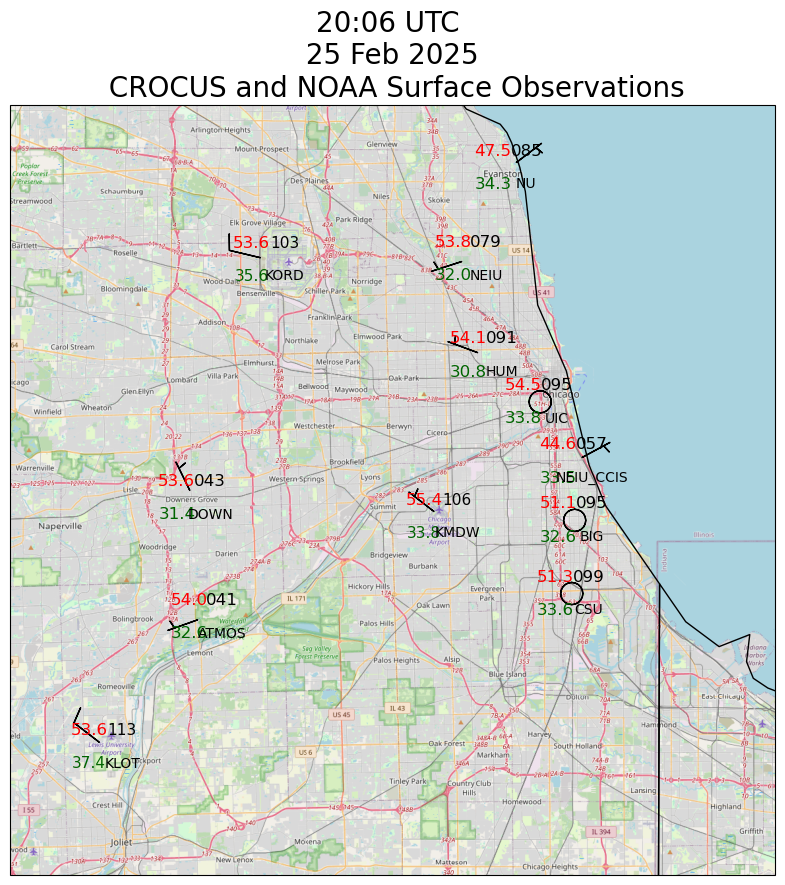

In [6]:
# Set up the map projection
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

# Use the Cartopy map projection to transform station locations to the map and
# then refine the number of stations plotted by setting a 300km radius
point_locs = proj.transform_points(ccrs.PlateCarree(), data['longitude'].values,
                                   data['latitude'].values)

fig = plt.figure(figsize=(20, 10))
tiler = OSM()
mercator = tiler.crs
#add_metpy_logo(fig, 1100, 300, size='large')
ax = fig.add_subplot(1, 1, 1, projection=mercator)


# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.NaturalEarthFeature("physical", "land", "10m"),
#              ec="red", fc="yellow", lw=2, alpha=0.4)
#ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_image(tiler, 11)

# Set plot bounds
ax.set_extent((-88.2, -87.4, 41.5, 42.1))

#
# Here's the actual station plot
#

# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'].values, data['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

stationplot.plot_parameter('NW', (data['temperature'].values * units.degC).to("degF"), color='red', formatter = '0.1f')
stationplot.plot_parameter('SW', (data['dewpoint'].values * units.degC).to("degF"),
                           color='darkgreen', formatter = '0.1f')

stationplot.plot_parameter('NE', data['mslp'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

ew, nw = wind_components((data['wind_mean_10s'].values * units.meter_per_second).to("knot") , 
                                data['wind_dir_10s'].values * units.degrees_north)

stationplot.plot_barb(ew, nw)

stationplot.plot_text('SE', data['station_id'].values, fontsize=10)



stationplot_metars = StationPlot(ax, metars['longitude'].values, metars['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

stationplot_metars.plot_parameter('NW', (metars['air_temperature'].values * units.degC).to("degF"), color='red', formatter = '0.1f')
stationplot_metars.plot_parameter('SW', (metars['dew_point_temperature'].values * units.degC).to("degF"),
                                  fontsize=11,
                           color='darkgreen', formatter = '0.1f')

stationplot_metars.plot_parameter('NE', metars['air_pressure_at_sea_level'].values,
                                  fontsize=11,
                           formatter=lambda v: format(10 * v, ' .0f')[-3:])


ew, nw = wind_components(metars['wind_speed'].values * units.knot , 
                                metars['wind_direction'].values * units.degrees_north)


stationplot_metars.plot_barb(ew, nw)
stationplot_metars.plot_text('SE', metars['station_id'].values, fontsize=10)
plt.title(pd.to_datetime(data.time.values[0]).strftime("%H:%M UTC \n %d %b %Y \n CROCUS and NOAA Surface Observations"), fontsize=20)
plt.savefig("current-conditions-crocus.png", dpi=300)